<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 코스피/코스닥 시총 100순위 변동
- 1주일/1달 주도주 분석
- 상승률 변동 (20, 60, 120, 250) 
- 강한 테마/이슈 뉴스검색어와 분석으로 연속성 검증
- 조회수순? 영향력 강한 1주일 이내 공시 분석기
- 앞으로 상장할 주식 1주일 치 이슈에 부합하나
- 업황 분석기: 지난 1주 1달치 업황 상승률/ 거래대금 순위

In [1]:
import requests
from datetime import date
import pandas as pd
from io import StringIO

In [2]:
market_type = {
    'all':'ALL',
    'kospi':'STK',
    'kosdaq':'KSQ'
}

def get_ranking(market, ranking_type, start_date, end_date):
  gen_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
  url = ''
  if ranking_type == 'highest': url = 'dbms/MDC/EASY/ranking/MDCEASY01501'
  elif ranking_type == 'traded': url = 'dbms/MDC/EASY/ranking/MDCEASY01601'
  elif ranking_type == 'marketcap': url = 'dbms/MDC/EASY/ranking/MDCEASY01701'
  data = {
    'locale': 'ko_KR',
    'mktId': market,
    'itmTpCd': '1',
    'itmTpCd2': '1',
    'trdDd': start_date,
    'strtDd': start_date,
    'endDd': end_date,
    'stkprcTpCd': 'Y',
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': url
  }
  gen_key = requests.post(gen_url, data=data).text
  down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
  data = {'code':gen_key}
  r = requests.post(down_url, data=data)
  r.encoding = 'EUC-KR'
  return pd.read_csv(StringIO(r.text))

In [3]:
def get_ranking_df(start='20220613', end='20220712', freq='1D', market='kospi', ranking_type='marketcap'):
  df = pd.DataFrame()
  for d in pd.date_range(start=start, end=end, freq=freq):
    t = pd.DataFrame()
    dt = d
    while t.empty:
      t = get_ranking(market_type[market], ranking_type, dt.strftime('%Y%m%d'), '')[['순위', '종목명']]
      dt += pd.DateOffset(1)
    t['date'] = dt
    df = df.append(t, ignore_index=True)
  return df

In [4]:
# korean font
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip'
!unzip "NotoSansCJKkr-hinted.zip"
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

--2022-07-13 13:20:19--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 173.194.210.128, 2607:f8b0:400c:c0f::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M  90.9MB/s    in 1.3s    

2022-07-13 13:20:21 (90.9 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoSansCJKkr-T

In [5]:
from matplotlib import font_manager, rc
font_fname = '/usr/share/fonts/truetype/NotoSansCJKkr-Medium.otf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator

def plot_bump(df='', n_top_ranked=10, title='Title'):
  top_sources = df[df["date"] == df["date"].max()].nsmallest(n_top_ranked, "순위")

  fig, ax = plt.subplots(figsize=(16, 8), subplot_kw=dict(ylim=(0.5, 0.5 + n_top_ranked)))
  #ax.xaxis.set_major_locator(MultipleLocator(1))
  ax.yaxis.set_major_locator(MultipleLocator(1))

  yax2 = ax.secondary_yaxis("right")
  yax2.yaxis.set_major_locator(FixedLocator(top_sources["순위"].to_list()))
  yax2.yaxis.set_major_formatter(FixedFormatter(top_sources["종목명"].to_list()))

  for i, j in df.groupby("종목명"):
      ax.plot("date", "순위", "o-", linewidth=3, markersize=7, data=j, mfc="w")

  ax.invert_yaxis()
  ax.set(xlabel="Date", ylabel="Rank", title="Market Cap")
  plt.tight_layout()

In [7]:
import dateutil.relativedelta

today = date.today().strftime("%Y%m%d")
previous = (date.today() - dateutil.relativedelta.relativedelta(months=1)).strftime("%Y%m%d")

findfont: Font family ['Noto Sans CJK KR'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Noto Sans CJK KR'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(

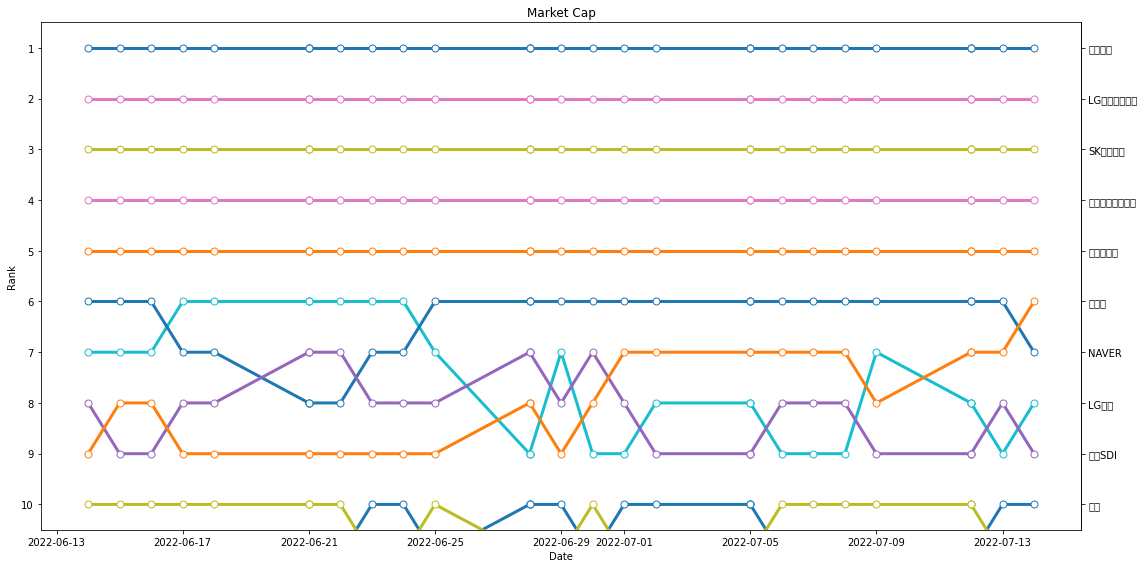

In [8]:
kospi_marketcap_ranking_df = get_ranking_df(previous, today, freq='1D', market='kospi', ranking_type='marketcap')
plot_bump(kospi_marketcap_ranking_df, 10, "Kospi Market Cap")

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54764 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_

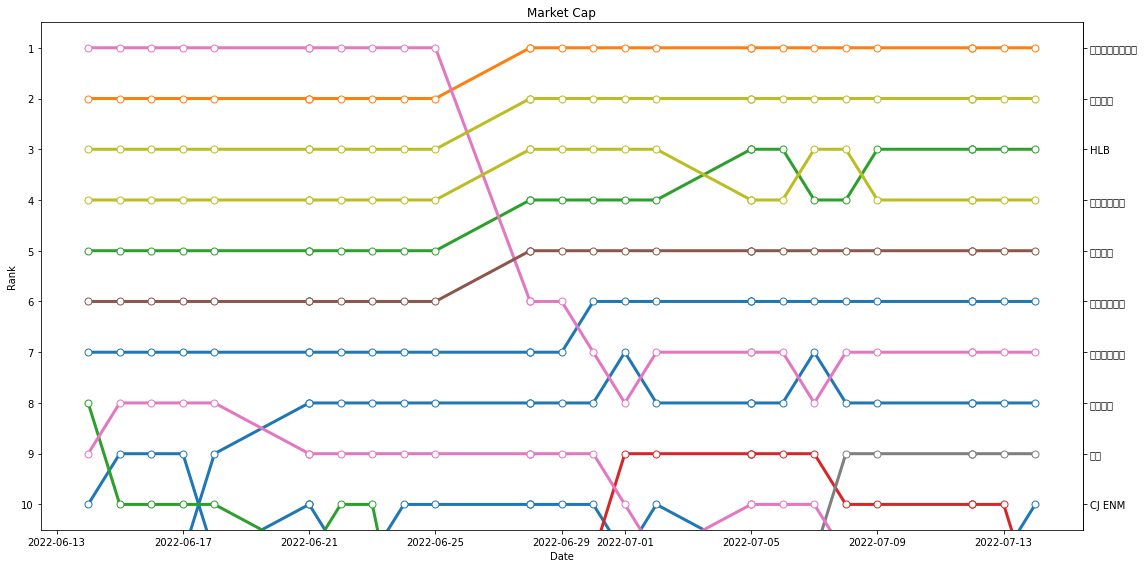

In [9]:
kosdaq_marketcap_ranking_df = get_ranking_df(previous, today, freq='1D', market='kosdaq', ranking_type='marketcap')
plot_bump(kosdaq_marketcap_ranking_df, 10, "Kosdaq Market Cap")

In [10]:
kospi_highest_ranking_df = get_ranking_df(previous, today, freq='1D', market='kospi', ranking_type='highest')
plot_bump(kospi_highest_ranking_df, 10, "Kospi Momentum")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-2f0bf2dc16ac>", line 1, in <module>
    kospi_highest_ranking_df = get_ranking_df(previous, today, freq='1D', market='kospi', ranking_type='highest')
  File "<ipython-input-3-1c5fb3e158e1>", line 7, in get_ranking_df
    t = get_ranking(market_type[market], ranking_type, dt.strftime('%Y%m%d'), '')[['순위', '종목명']]
  File "<ipython-input-2-f84eded35c8c>", line 31, in get_ranking
    r = requests.post(down_url, data=data)
  File "/usr/local/lib/python3.7/dist-packages/requests/api.py", line 119, in post
    return request('post', url, data=data, json=json, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/requests/sessions.

KeyboardInterrupt: ignored

In [ ]:
kosdaq_highest_ranking_df = get_ranking_df(previous, today, freq='1D', market='kosdaq', ranking_type='highest')
plot_bump(kosdaq_highest_ranking_df, 10, "Kosdaq Momentum")

In [ ]:
kospi_traded_ranking_df = get_ranking_df(previous, today, freq='1D', market='kospi', ranking_type='traded')
plot_bump(kospi_highest_ranking_df, 10, "Kospi Traded")

In [ ]:
kospi_traded_ranking_df = get_ranking_df(previous, today, freq='1D', market='kosdaq', ranking_type='traded')
plot_bump(kospi_traded_ranking_df, 10, "Kosdaq Traded")

In [ ]:
get_ranking(market_type['kosdaq'], 'traded', '20210101', '20220101').sort_values('등락률', ascending=False)

In [ ]:
today